# Neural Network

At first, we have to import datasets to Dataframe.

In [1]:
import numpy as np
import pandas as pd
import glob

# for multiple files
PATH = './All/*.csv'
data = pd.concat(map(pd.read_csv, glob.glob(PATH)))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93203 entries, 0 to 1044
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         93203 non-null  object
 1   Time         93203 non-null  object
 2   震央地名         93203 non-null  object
 3   Lat          93203 non-null  object
 4   Long         93203 non-null  object
 5   Depth        93203 non-null  int64 
 6   M            93203 non-null  object
 7   最大震度         93203 non-null  object
 8   Source.Name  89371 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.1+ MB
None


For analyzation, we use only date, time, position, depth and magnitude.

In [2]:
data = data[['Date', 'Time', 'Lat', 'Long', 'Depth', 'M']]
data['M'] = data['M'].apply(pd.to_numeric, errors='coerce')
data = data.dropna()
data['M'] = data['M'].astype(np.float64)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85334 entries, 0 to 1044
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    85334 non-null  object 
 1   Time    85334 non-null  object 
 2   Lat     85334 non-null  object 
 3   Long    85334 non-null  object 
 4   Depth   85334 non-null  int64  
 5   M       85334 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 4.6+ MB


As you can see, latitude and longitude of the positions are not in decimal. For analyzation, we have to convert from dms to decimal.

In [3]:
import re
def dms2dd(s):
    degrees, minutes, direction = re.split('[°\']+', s)
    dd = float(degrees) + float(minutes)/60
    return dd

Apply dms2dd function to the dataframe

In [4]:
data['Lat'] = data['Lat'].apply(dms2dd)
data['Long'] = data['Long'].apply(dms2dd)

In some places, the data is incorrect or unusable, so we have to remove all of these. After removing, we have to check the amount of data for analyzation. After conversion, we have to cast the data to be float.

In [5]:
import numpy as np
data = data.astype({'Lat': np.float64, 'Long': np.float64, 'M': np.float64, 'Depth': np.float64})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85334 entries, 0 to 1044
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    85334 non-null  object 
 1   Time    85334 non-null  object 
 2   Lat     85334 non-null  float64
 3   Long    85334 non-null  float64
 4   Depth   85334 non-null  float64
 5   M       85334 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.6+ MB


# Convert 'Date' and 'Time' to Timestamp

At first, we have to use array to store the Timestamp after convert from 'Date' and 'Time'.

In [6]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # if the date and time cannot be converted
        timestamp.append('ValueError')

Insert Timestamp to dataframe

In [7]:
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values

As you can see above, the data in dataframe is not in order by time, so we have to reorder it. We also have to remove the Timestamp Error

In [8]:
data = data[data.Timestamp != 'ValueError']
data.sort_values(by='Timestamp', inplace=True)
data.head()

,Date,Time,Lat,Long,Depth,M,Timestamp
680,1/1/1985,0:58:14,36.103333,141.156667,38.0,3.9,473356694.0
679,1/1/1985,13:19:52,35.825000,137.565000,11.0,3.9,473401192.0
678,1/1/1985,19:41:54,42.181667,142.558333,29.0,3.2,473424114.0
677,1/2/1985,3:31:04,37.018333,141.791667,46.0,4.6,473452264.0
676,1/3/1985,3:54:45,43.361667,145.801667,48.0,3.1,473540085.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85334 entries, 680 to 1537
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       85334 non-null  object 
 1   Time       85334 non-null  object 
 2   Lat        85334 non-null  float64
 3   Long       85334 non-null  float64
 4   Depth      85334 non-null  float64
 5   M          85334 non-null  float64
 6   Timestamp  85334 non-null  float64
dtypes: float64(5), object(2)
memory usage: 5.2+ MB


# Split the dataframe to train and test set

Check the columns of dataframe

In [10]:
data.head()

,Date,Time,Lat,Long,Depth,M,Timestamp
680,1/1/1985,0:58:14,36.103333,141.156667,38.0,3.9,473356694.0
679,1/1/1985,13:19:52,35.825000,137.565000,11.0,3.9,473401192.0
678,1/1/1985,19:41:54,42.181667,142.558333,29.0,3.2,473424114.0
677,1/2/1985,3:31:04,37.018333,141.791667,46.0,4.6,473452264.0
676,1/3/1985,3:54:45,43.361667,145.801667,48.0,3.1,473540085.0


For Machine Learning, 'Date' and 'Time' are unnecessary. So, we remove both of them from the dataframe.

In [11]:
data = data.drop(['Date', 'Time'], axis=1)

Before that, we normalize the data

In [12]:
norm_Lat = (data['Lat']-data['Lat'].mean())/data['Lat'].std()
norm_Long = (data['Long']-data['Long'].mean())/data['Long'].std()
norm_M = (data['M']-data['M'].mean())/data['M'].std()
norm_Time = (data['Timestamp']-data['Timestamp'].mean())/data['Timestamp'].std()
norm_depth = (data['Depth']-data['Depth'].mean())/data['Depth'].std()
data_copy = data.copy()
data_copy['Lat'] = norm_Lat
data_copy['Long'] = norm_Long
data_copy['M'] = norm_M
data_copy['Timestamp'] = norm_Time
data_copy['Depth'] = norm_depth
print(data_copy.head())

          Lat      Long     Depth         M  Timestamp
680  0.136779  0.703352  0.333917  0.649842  -2.465423
679  0.063646 -0.038494 -0.417347  0.649842  -2.465267
678  1.733879  0.992862  0.083496 -0.105507  -2.465187
677  0.377198  0.834509  0.556514  1.405192  -2.465088
676  2.043927  1.662761  0.612163 -0.213414  -2.464780


# Neural Network

In [16]:
X = data_copy[['Timestamp', 'Lat', 'Long']]
y = data_copy[['M', 'Depth']]

In [17]:
from sklearn.model_selection import train_test_split
# define the test size would be 20% of all data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape)

(76800, 3) (8534, 3)


In [18]:
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

def create_model(activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(256, activation=activation, input_shape=(3,)))
    model.add(Dense(480, activation=activation))
    model.add(Dense(2, activation='linear'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['MeanSquaredError'])
    
    return model

In [20]:
model = create_model('relu', Adam(learning_rate=0.05), 'mse')
history = model.fit(X_train, y_train, epochs=500, batch_size=10000, validation_split=0.1)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-03 09:25:40.504447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-03 09:25:40.504896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/500


2022-11-03 09:25:40.787696: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-03 09:25:41.104138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 65ms/step - loss: 11.9724 - mean_squared_error: 11.9724 - val_loss: 1.1374 - val_mean_squared_error: 1.1374
Epoch 2/500
4/7 [================>.............] - ETA: 0s - loss: 1.1246 - mean_squared_error: 1.1246

2022-11-03 09:25:41.671547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 24ms/step - loss: 1.0698 - mean_squared_error: 1.0698 - val_loss: 1.0048 - val_mean_squared_error: 1.0048
Epoch 3/500
7/7 [==============================] - 0s 25ms/step - loss: 0.9575 - mean_squared_error: 0.9575 - val_loss: 0.8911 - val_mean_squared_error: 0.8911
Epoch 4/500
7/7 [==============================] - 0s 27ms/step - loss: 0.8813 - mean_squared_error: 0.8813 - val_loss: 0.8143 - val_mean_squared_error: 0.8143
Epoch 5/500
7/7 [==============================] - 0s 32ms/step - loss: 0.8265 - mean_squared_error: 0.8265 - val_loss: 0.7807 - val_mean_squared_error: 0.7807
Epoch 6/500
7/7 [==============================] - 0s 28ms/step - loss: 0.7927 - mean_squared_error: 0.7927 - val_loss: 0.7510 - val_mean_squared_error: 0.7510
Epoch 7/500
7/7 [==============================] - 0s 39ms/step - loss: 0.7746 - mean_squared_error: 0.7746 - val_loss: 0.7455 - val_mean_squared_error: 0.7455
Epoch 8/500
7/7 [==============================] - 0

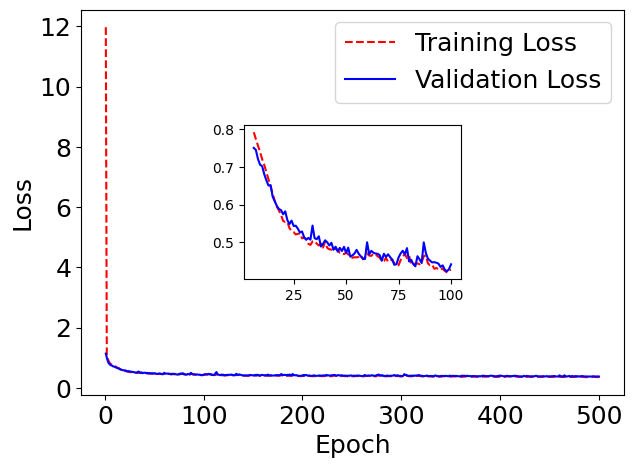

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig, ax = plt.subplots(1, figsize=[7, 5])
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.tick_params(labelsize=18)
axins2 = inset_axes(ax, width='40%', height='40%', loc='center')
axins2.tick_params(labelleft=True, labelbottom=True)
plt.plot(epoch_count[5:100], training_loss[5:100], 'r--')
plt.plot(epoch_count[5:100], test_loss[5:100], 'b-')
plt.show();

In [22]:
model.evaluate(X_test, y_test)

267/267 [==============================] - 1s 5ms/step - loss: 0.3905 - mean_squared_error: 0.3905


[0.3905055522918701, 0.3905055522918701]

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 480)               123360    
                                                                 
 dense_2 (Dense)             (None, 2)                 962       
                                                                 
Total params: 125,346
Trainable params: 125,346
Non-trainable params: 0
_________________________________________________________________


In [28]:
from sklearn.metrics import mean_squared_error
Y_test = y_test['M']*data['M'].std()+data['M'].mean()
y_pred = model.predict(X_test)
y_pred_M = ([row[0] for row in y_pred])
y_pred_M = np.array(y_pred_M)
Y_pred_M = y_pred_M*data['M'].std()+data['M'].mean()
print(mean_squared_error(Y_test, Y_pred_M))

267/267 [==============================] - 1s 2ms/step
0.40684981982975676


In [25]:
Y_test = np.array(Y_test)
print(Y_test)

[2.  2.2 3.1 ... 3.1 2.6 3.7]


In [26]:
print(Y_pred_M)

[2.9133308 2.4597435 3.4839587 ... 3.8725743 2.549524  3.6369133]


In [27]:
from sklearn.metrics import mean_squared_error
Y_test = y_test['Depth']*data['Depth'].std()+data['Depth'].mean()
y_pred = model.predict(X_test)
y_pred_D = ([row[1] for row in y_pred])
y_pred_D = np.array(y_pred_D)
Y_pred_D = y_pred_D*data['Depth'].std()+data['Depth'].mean()
print(mean_squared_error(Y_test, Y_pred_D))

267/267 [==============================] - 1s 2ms/step
396.8934362285743
